# Data Loading

In [14]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings("ignore")

In [3]:
# fetch dataset 
productivity_prediction_of_garment_employees = fetch_ucirepo(id=597) 

productivity_data = productivity_prediction_of_garment_employees.data
productivity_df = pd.DataFrame(productivity_data['original'])

In [4]:
productivity_df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [17]:
def dataframe_info(df):
    report = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Count', 'Unique Sample', 'Missing Values', 'Missing Percentage'])
    for column in df.columns:
        data_type = df[column].dtype
        unique_count = df[column].nunique()
        unique_sample = df[column].unique()[:5]
        missing_values = df[column].isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        report = pd.concat([report, pd.DataFrame({'Column': [column],
                                                      'Data Type': [data_type],
                                                      'Unique Count': [unique_count],
                                                      'Unique Sample': [unique_sample],
                                                      'Missing Values': [missing_values],
                                                      'Missing Percentage': [missing_percentage.round(4)]})],
                             ignore_index=True)
    return report

In [18]:
dataframe_info(productivity_df)

,Column,Data Type,Unique Count,Unique Sample,Missing Values,Missing Percentage
0,date,object,59,"[1/1/2015, 1/3/2015, 1/4/2015, 1/5/2015, 1/6/2...",0,0.0000
1,quarter,object,5,"[Quarter1, Quarter2, Quarter3, Quarter4, Quart...",0,0.0000
2,department,object,2,"[sweing, finishing]",0,0.0000
3,day,object,6,"[Thursday, Saturday, Sunday, Monday, Tuesday]",0,0.0000
4,team,int64,12,"[8, 1, 11, 12, 6]",0,0.0000
5,targeted_productivity,float64,9,"[0.8, 0.75, 0.7, 0.65, 0.6]",0,0.0000
6,smv,float64,70,"[26.16, 3.94, 11.41, 25.9, 28.08]",0,0.0000
7,wip,float64,548,"[1108.0, nan, 968.0, 1170.0, 984.0]",506,42.2723
8,over_time,int64,143,"[7080, 960, 3660, 1920, 6720]",0,0.0000
9,incentive,int64,48,"[98, 0, 50, 38, 45]",0,0.0000


In [21]:
len(productivity_df)

1197

In [19]:
#change date to datetime data type
productivity_df['date'] = pd.to_datetime(productivity_df['date'])

# EDA

## Univariate

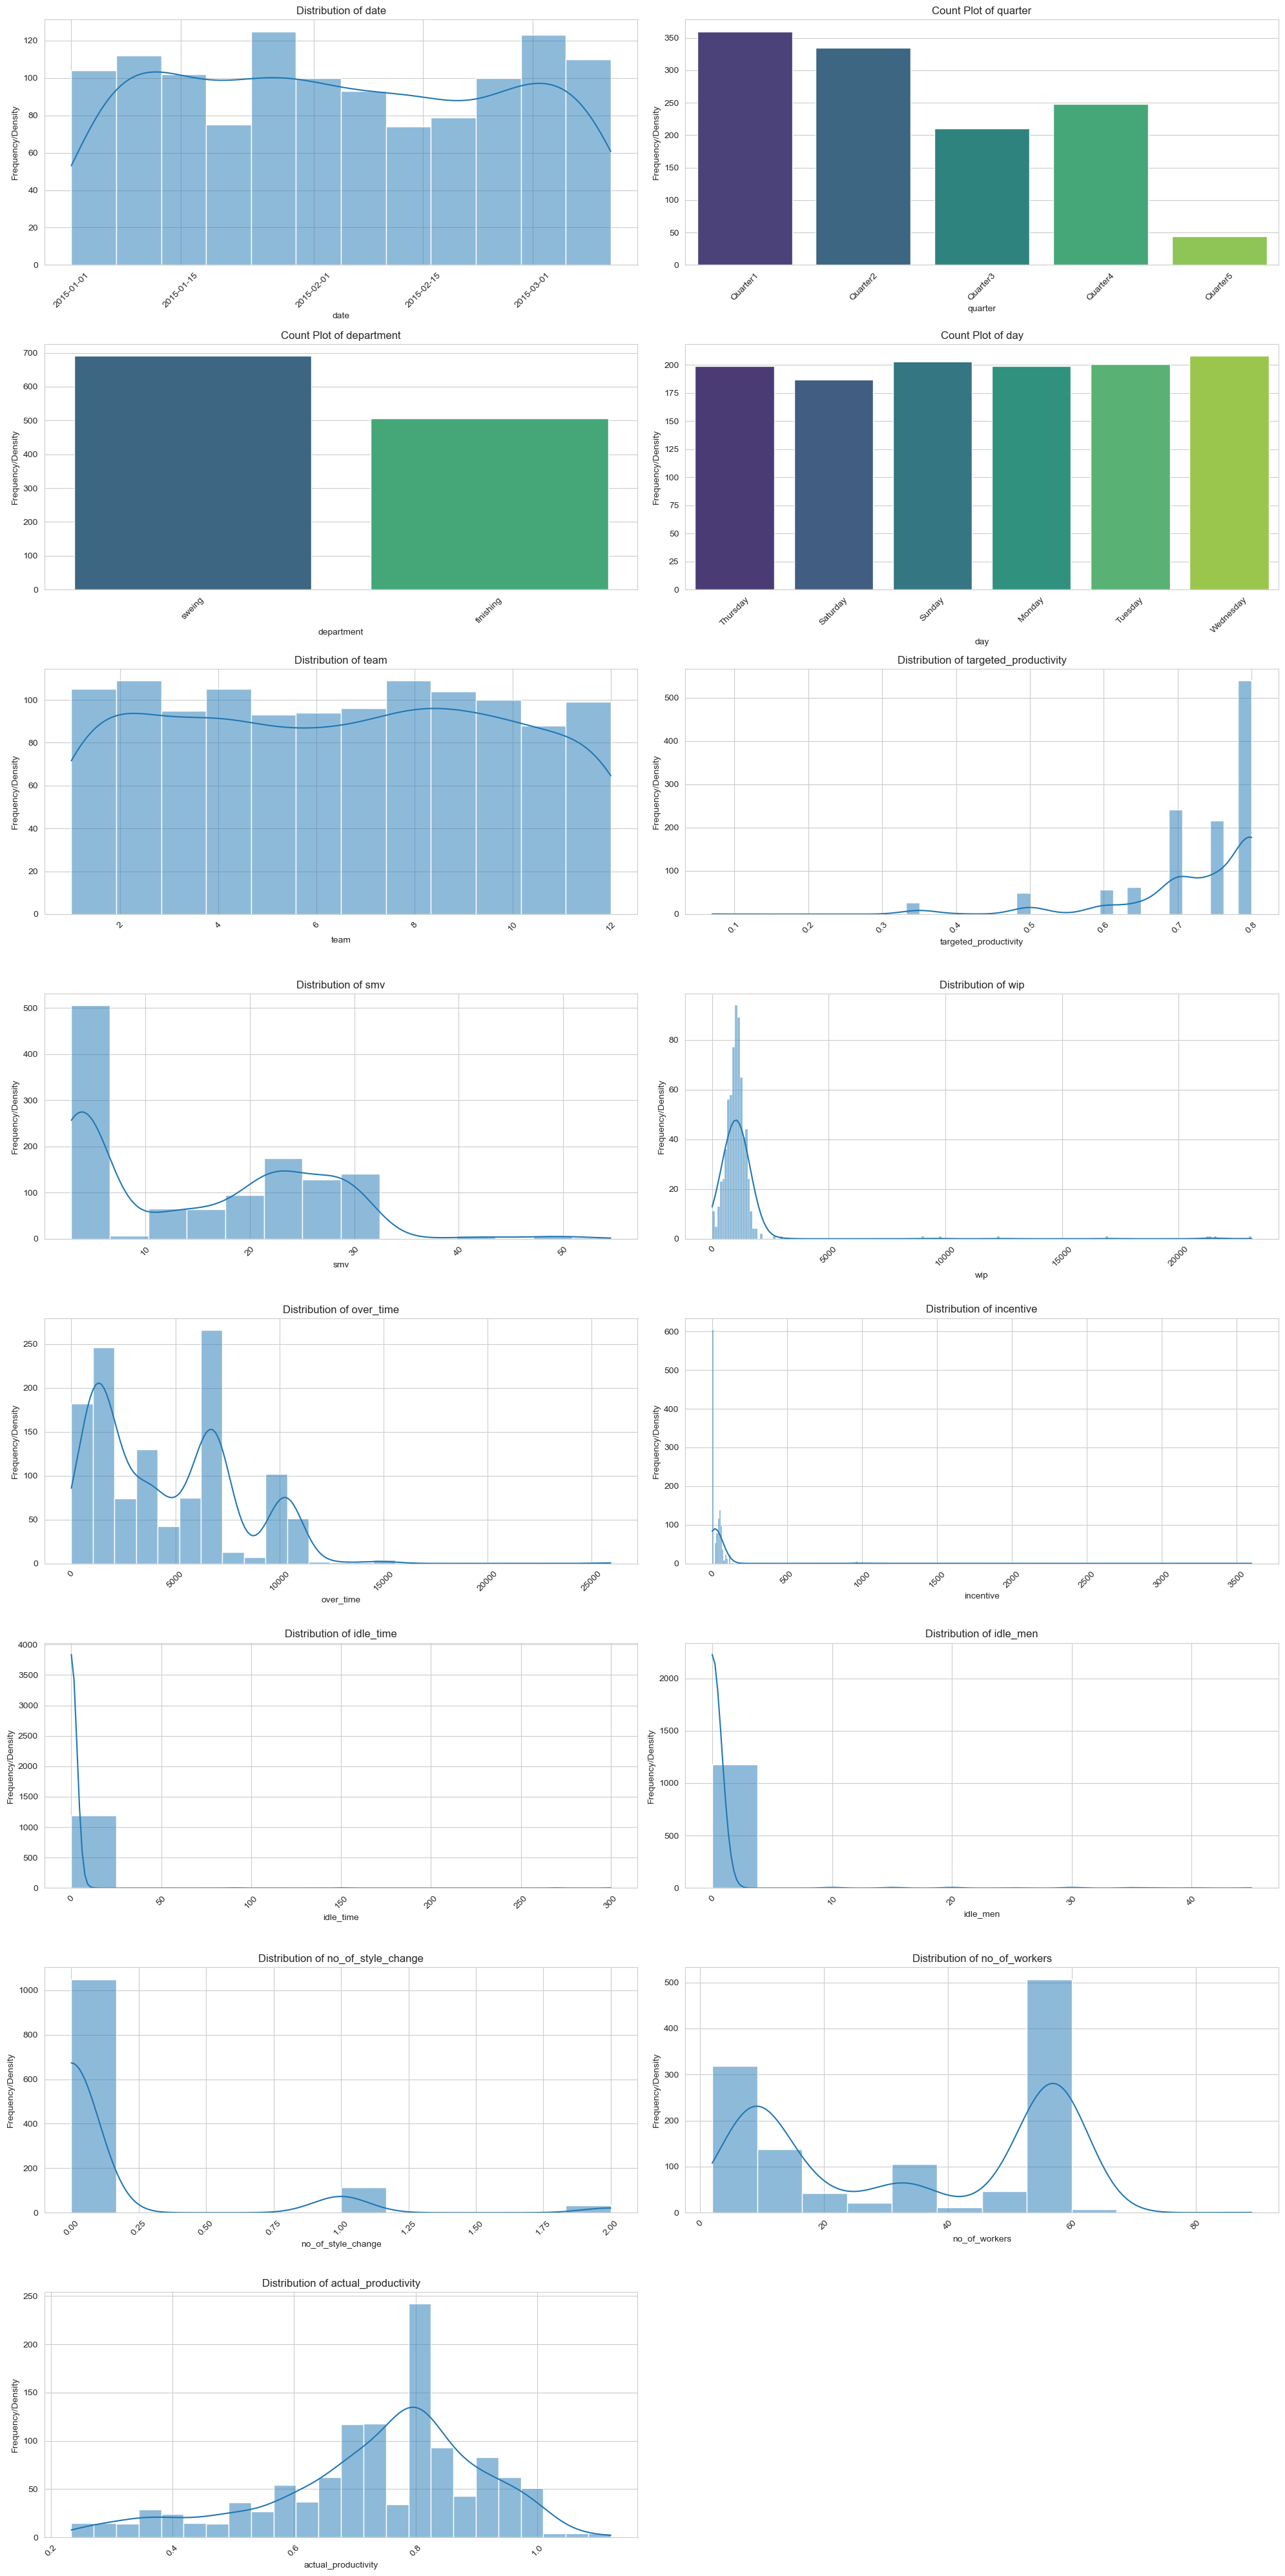

In [26]:
# Function to perform and plot univariate analysis
def univariate_analysis(df, columns_to_analyze=None, figsize=None):
    """
    This function performs univariate analysis for specified or all columns in a DataFrame. 
    It generates appropriate plots (countplot for categorical, histplot for numerical) and displays them in a grid layout.

    Parameters:
        df (pandas.DataFrame): The DataFrame to analyze.
        columns_to_analyze (list, optional): A list of column names to analyze. If None, analyzes all columns.
        figsize (tuple, optional): The size of the figure to display the plots (width, height).

    Returns:
        None: Displays the plots.
    """
    
    # Set the aesthetic style of the plots (optional)
    sns.set_style("whitegrid")

    # If no specific columns are provided, analyze all
    if columns_to_analyze is None:
        columns_to_analyze = df.columns

    if figsize is None:
        figsize = (20, 5 * ((len(columns_to_analyze) + 1) // 2))

    # Calculate number of rows and columns for the subplot grid
    num_plots = len(columns_to_analyze)
    num_rows = (num_plots + 1) // 2
    num_cols = 2

    # Create the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the array for easy iteration

    # Function for individual plot generation
    def plot_single_variable(data, column, ax):
        if data[column].dtype == 'object':
            sns.countplot(data=data, x=column, palette='viridis', ax=ax)
            ax.set_title(f'Count Plot of {column}')
        else:
            sns.histplot(data[column], kde=True, ax=ax)
            ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency/Density')
        ax.tick_params(axis='x', rotation=45)

    # Generate plots for each column
    for i, column in enumerate(columns_to_analyze):
        plot_single_variable(df, column, axes[i])

    # Remove any extra empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better readability
    plt.tight_layout()

    # Show the plots
    plt.show()

univariate_analysis(productivity_df)

## Understanding Quarters

In [22]:
# Calculate the number of unique days
num_days = productivity_df['date'].nunique()

# Get the date range
start_date = productivity_df['date'].min()
end_date = productivity_df['date'].max()

# Calculate the total date range
date_range = end_date - start_date

print(f"The data covers {num_days} unique days.")
print(f"Date range: from {start_date.date()} to {end_date.date()}")
print(f"Total time span: {date_range.days + 1} days")

The data covers 59 unique days.
Date range: from 2015-01-01 to 2015-03-11
Total time span: 70 days


In [23]:
# Check the unique values in the 'quarter' column
print("Unique quarters:", productivity_df['quarter'].unique())

# Count the occurrences of each quarter
print("\nQuarter counts:")
print(productivity_df['quarter'].value_counts())

# Check if there are any gaps in the date range
all_dates = pd.date_range(start=start_date, end=end_date)
missing_dates = all_dates.difference(productivity_df['date'])

print(f"\nNumber of days without data: {len(missing_dates)}")
print("Sample of missing dates:")
print(missing_dates[:5])  # Print first 5 missing dates as a sample

# Check the distribution of data across days of the week
print("\nData distribution across days of the week:")
print(productivity_df['day'].value_counts())

Unique quarters: ['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']

Quarter counts:
quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

Number of days without data: 11
Sample of missing dates:
DatetimeIndex(['2015-01-02', '2015-01-09', '2015-01-16', '2015-01-23',
               '2015-01-30'],
              dtype='datetime64[ns]', freq=None)

Data distribution across days of the week:
day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64


In [24]:
# Group by quarter and get the date range for each
quarter_ranges = productivity_df.groupby('quarter').agg({
    'date': ['min', 'max']
})

# Flatten the column names
quarter_ranges.columns = ['start_date', 'end_date']

# Sort by start date to see the progression
quarter_ranges = quarter_ranges.sort_values('start_date')

# Calculate the number of days in each quarter
quarter_ranges['days'] = (quarter_ranges['end_date'] - quarter_ranges['start_date']).dt.days + 1

# Calculate the number of data points in each quarter
quarter_counts = productivity_df['quarter'].value_counts().sort_index()

# Add the count to our results
quarter_ranges['data_points'] = quarter_counts

print("Quarter Date Ranges:")
print(quarter_ranges)

# Calculate any gaps between quarters
gaps = []
for i in range(len(quarter_ranges) - 1):
    current_end = quarter_ranges.iloc[i]['end_date']
    next_start = quarter_ranges.iloc[i+1]['start_date']
    gap = (next_start - current_end).days - 1
    if gap > 0:
        gaps.append(f"Gap of {gap} days between {quarter_ranges.index[i]} and {quarter_ranges.index[i+1]}")

if gaps:
    print("\nGaps between quarters:")
    for gap in gaps:
        print(gap)
else:
    print("\nNo gaps between quarters.")

Quarter Date Ranges:
         start_date   end_date  days  data_points
quarter                                          
Quarter1 2015-01-01 2015-03-07    66          360
Quarter2 2015-01-08 2015-03-11    63          335
Quarter3 2015-01-15 2015-02-19    36          210
Quarter4 2015-01-22 2015-02-28    38          248
Quarter5 2015-01-29 2015-01-31     3           44

No gaps between quarters.


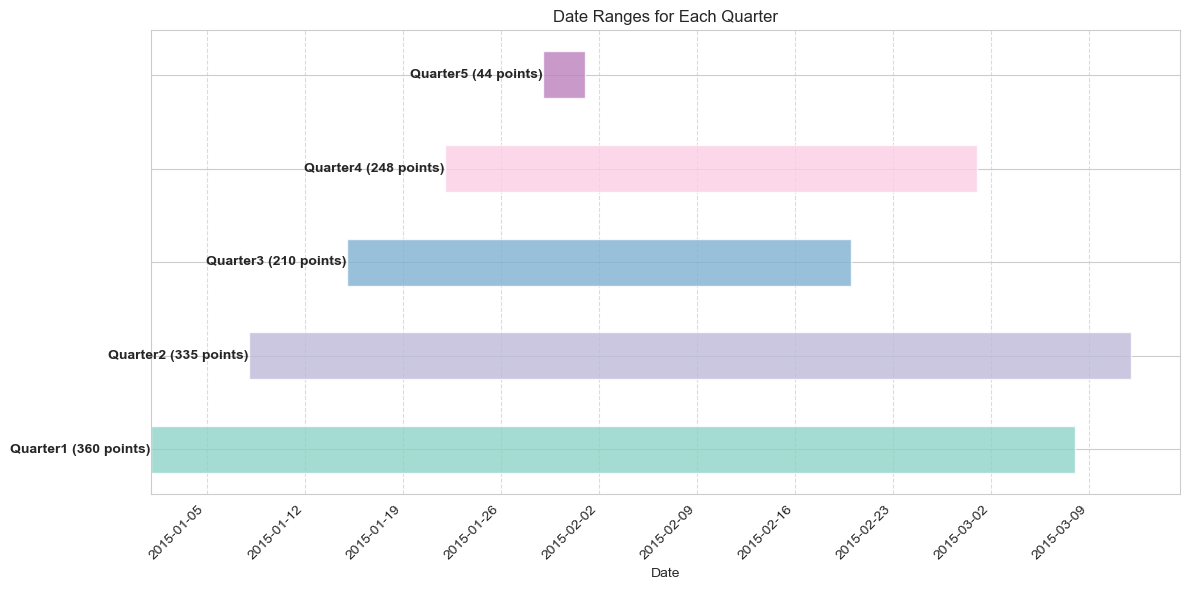

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure quarter_ranges is sorted by start_date
quarter_ranges = quarter_ranges.sort_values('start_date')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot horizontal bars for each quarter
for i, (quarter, row) in enumerate(quarter_ranges.iterrows()):
    ax.barh(i, (row['end_date'] - row['start_date']).days + 1, 
            left=mdates.date2num(row['start_date']), 
            height=0.5, 
            align='center',
            color=plt.cm.Set3(i / len(quarter_ranges)),
            alpha=0.8)
    
    # Add text labels
    ax.text(mdates.date2num(row['start_date']), i, 
            f"{quarter} ({row['data_points']} points)", 
            va='center', ha='right', fontweight='bold')

# Customize the plot
ax.set_yticks(range(len(quarter_ranges)))
ax.set_yticklabels([])
ax.set_xlabel('Date')
ax.set_title('Date Ranges for Each Quarter')

# Format x-axis to show dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

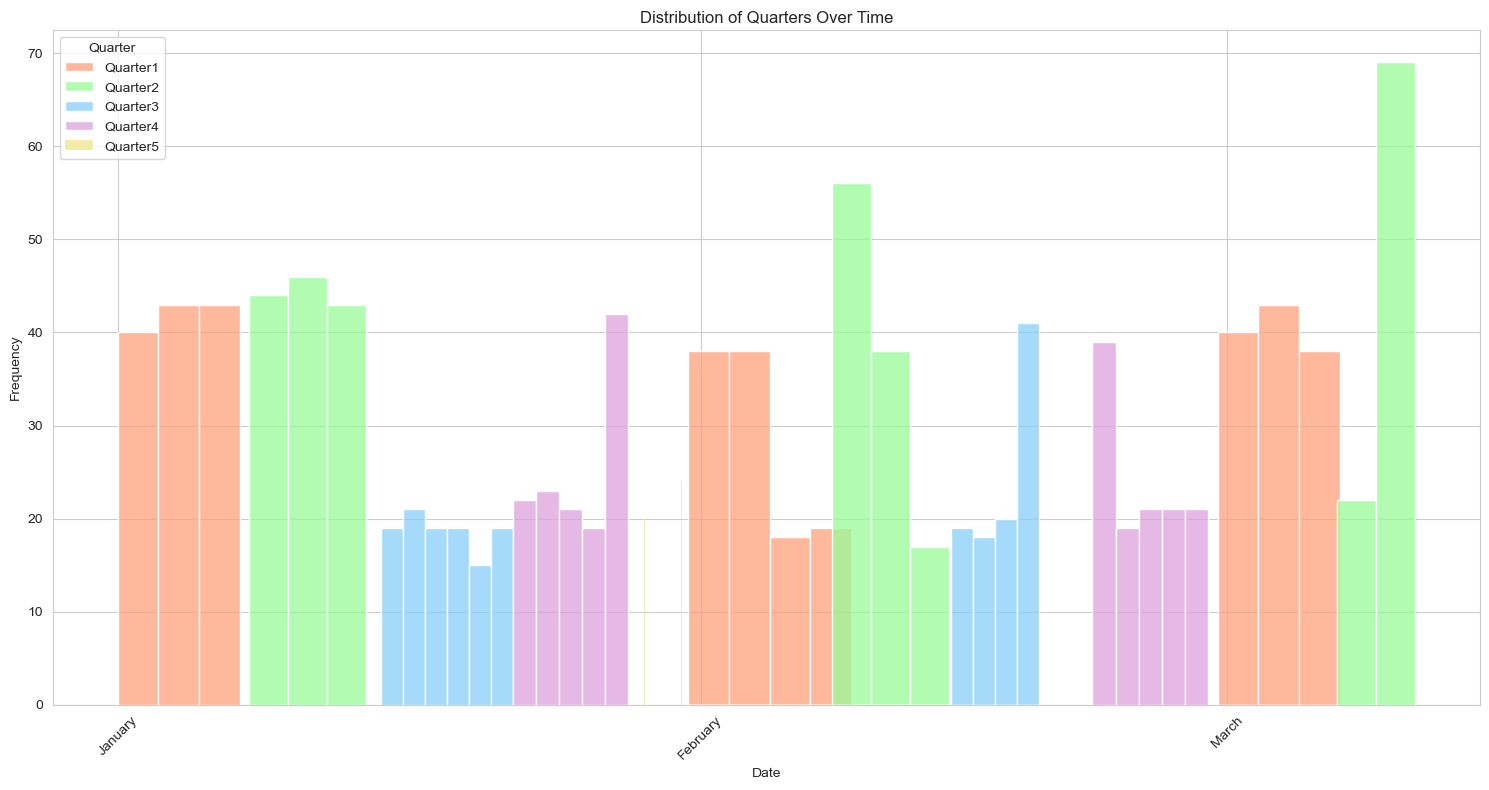

Date range of each quarter:
Quarter1: 2015-01-01 to 2015-03-07
Quarter2: 2015-01-08 to 2015-03-11
Quarter3: 2015-01-15 to 2015-02-19
Quarter4: 2015-01-22 to 2015-02-28
Quarter5: 2015-01-29 to 2015-01-31


In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

# Ensure the date is in datetime format
productivity_df['date'] = pd.to_datetime(productivity_df['date'])

# Create the plot
plt.figure(figsize=(15, 8))

# Define colors for quarters
color_map = {'Quarter1': '#FFA07A', 'Quarter2': '#98FB98', 'Quarter3': '#87CEFA', 
             'Quarter4': '#DDA0DD', 'Quarter5': '#F0E68C'}

# Create histograms for each quarter
for quarter in sorted(productivity_df['quarter'].unique()):
    quarter_data = productivity_df[productivity_df['quarter'] == quarter]
    sns.histplot(data=quarter_data, x='date', bins=30, 
                 color=color_map[quarter], label=quarter, 
                 kde=False, element="bars")

plt.title('Distribution of Quarters Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')

# Format x-axis to show month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.xticks(rotation=45)

plt.legend(title='Quarter')
plt.tight_layout()
plt.show()

# Print some additional information
print("Date range of each quarter:")
for quarter in sorted(productivity_df['quarter'].unique()):
    quarter_data = productivity_df[productivity_df['quarter'] == quarter]
    print(f"{quarter}: {quarter_data['date'].min().strftime('%Y-%m-%d')} to {quarter_data['date'].max().strftime('%Y-%m-%d')}")

In [37]:
# Change 'Quarter5' to 'Quarter4' 
productivity_df['quarter'] = productivity_df['quarter'].replace('Quarter5', 'Quarter4')

## Investigate missingness on wip

In [40]:
## Python 
def md_pattern_fun(dat_df):
 # Getting all column names
 all_cols = dat_df.columns.tolist()
 # Getting the names of columns with some missing values
 miss_cols = [col for col in all_cols if dat_df[col].isnull().sum()]
 if miss_cols == all_cols: dat_df['index'] = dat_df.index
 # Removing columns with no missing values
 dat_df = dat_df.loc[:,miss_cols]
 #Showing total number of missing values per variable
 print(dat_df.isnull().sum())
 # Adding count value
 dat_df['count'] = 1
 # Showing count for missingness combinations
 print(dat_df.isnull().groupby(miss_cols).count())

md_pattern_fun(productivity_df)


wip    506
dtype: int64
       count
wip         
False    691
True     506


In [59]:
productivity_df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,2015-03-11,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,2015-03-11,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,2015-03-11,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [62]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols

# Assuming productivity_df is already defined
min_data_df = productivity_df.copy()
min_data_df['wip'] = np.where(min_data_df['wip'].isna(), min_data_df['wip'].min(), min_data_df['wip'])

max_data_df = productivity_df.copy()
max_data_df['wip'] = np.where(max_data_df['wip'].isna(), max_data_df['wip'].max(), max_data_df['wip'])


In [70]:
print(ols("actual_productivity ~ wip + no_of_workers + smv + team", data=productivity_df).fit().summary())


                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.081
Model:                             OLS   Adj. R-squared:                  0.075
Method:                  Least Squares   F-statistic:                     15.03
Date:                 Wed, 17 Jul 2024   Prob (F-statistic):           8.73e-12
Time:                         16:54:14   Log-Likelihood:                 338.26
No. Observations:                  691   AIC:                            -666.5
Df Residuals:                      686   BIC:                            -643.8
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8304      0.041 

In [71]:
print(ols("actual_productivity ~ wip + no_of_workers + smv + team", data=min_data_df).fit().summary())


                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.066
Model:                             OLS   Adj. R-squared:                  0.063
Method:                  Least Squares   F-statistic:                     21.07
Date:                 Wed, 17 Jul 2024   Prob (F-statistic):           8.37e-17
Time:                         16:54:32   Log-Likelihood:                 432.76
No. Observations:                 1197   AIC:                            -855.5
Df Residuals:                     1192   BIC:                            -830.1
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8087      0.013 

In [72]:
print(ols("actual_productivity ~ wip + no_of_workers + smv + team", data=max_data_df).fit().summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.064
Model:                             OLS   Adj. R-squared:                  0.061
Method:                  Least Squares   F-statistic:                     20.26
Date:                 Wed, 17 Jul 2024   Prob (F-statistic):           3.70e-16
Time:                         16:54:36   Log-Likelihood:                 431.23
No. Observations:                 1197   AIC:                            -852.5
Df Residuals:                     1192   BIC:                            -827.0
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7428      0.039 

The results are as follows:
- The coefficient based on the available data is 9.434e-06
- The coefficient based on replacing the missing values with the minimum of wip is 8.552e-06.
- The coefficient based on replacing the missing values with the maximum of wip is 2.234e-06.

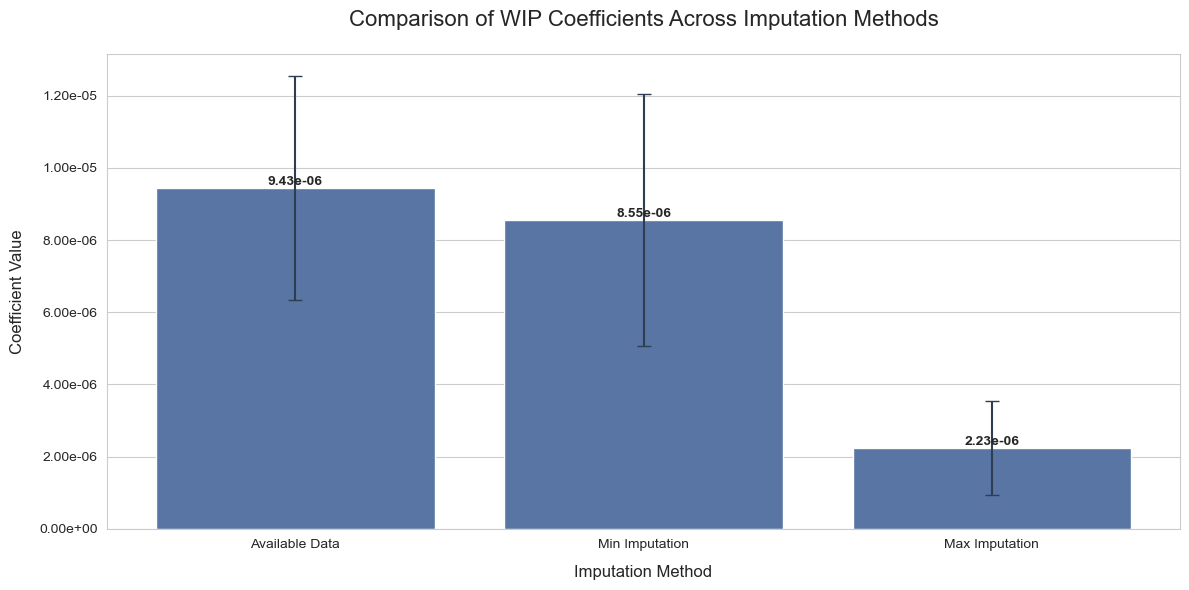

In [74]:
def extract_wip_stats(model):
    results = model.fit()
    return results.params['wip'], results.bse['wip']

# Run regressions and extract statistics
models = {
    'Available Data': ols("actual_productivity ~ wip + no_of_workers + smv + team", data=productivity_df),
    'Min Imputation': ols("actual_productivity ~ wip + no_of_workers + smv + team", data=min_data_df),
    'Max Imputation': ols("actual_productivity ~ wip + no_of_workers + smv + team", data=max_data_df)
}

data = pd.DataFrame({
    'Method': models.keys(),
    'Coefficient': [extract_wip_stats(model)[0] for model in models.values()],
    'Std Error': [extract_wip_stats(model)[1] for model in models.values()]
})

# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Method', y='Coefficient', data=data, 
                 capsize=0.1, errcolor='#2C3E50', errwidth=2)

# Add error bars
ax.errorbar(x=range(len(data)), y=data['Coefficient'], yerr=data['Std Error'], 
            fmt='none', c='#2C3E50', capsize=5)

# Customize the plot
ax.set_title('Comparison of WIP Coefficients Across Imputation Methods', fontsize=16, pad=20)
ax.set_xlabel('Imputation Method', fontsize=12, labelpad=10)
ax.set_ylabel('Coefficient Value', fontsize=12, labelpad=10)

# Format y-axis to scientific notation
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2e}'))

# Add value labels on the bars
for i, v in enumerate(data['Coefficient']):
    ax.text(i, v, f'{v:.2e}', ha='center', va='bottom', fontweight='bold')

# Adjust layout and display
plt.tight_layout()
plt.show()

Key Observations:

1. Consistency in Direction:
- All coefficients here remain positive across different imputation methods. This suggests that the relationship between 'wip' and actual productivity is consistently positive, regardless of how missing values are handled.

2. Magnitude Differences:
While the signs don't change, there are noticeable differences in magnitude:
- The minimum imputation approach yields a result close to the available data approach.
- The maximum imputation approach results in a coefficient about 4 times smaller than the available data approach.


3. Sensitivity to Imputation Method:
- The substantial difference between minimum and maximum imputation results indicates that the model is sensitive to how missing 'wip' values are handled.

4. Potential Bias:
- The variation in coefficients suggests that simply dropping rows with missing 'wip' data or using a single imputation method could lead to biased estimates of the relationship between 'wip' and productivity.

5. Importance of 'wip':
The fact that different imputation methods lead to different coefficients underscores the importance of the 'wip' variable in the model.

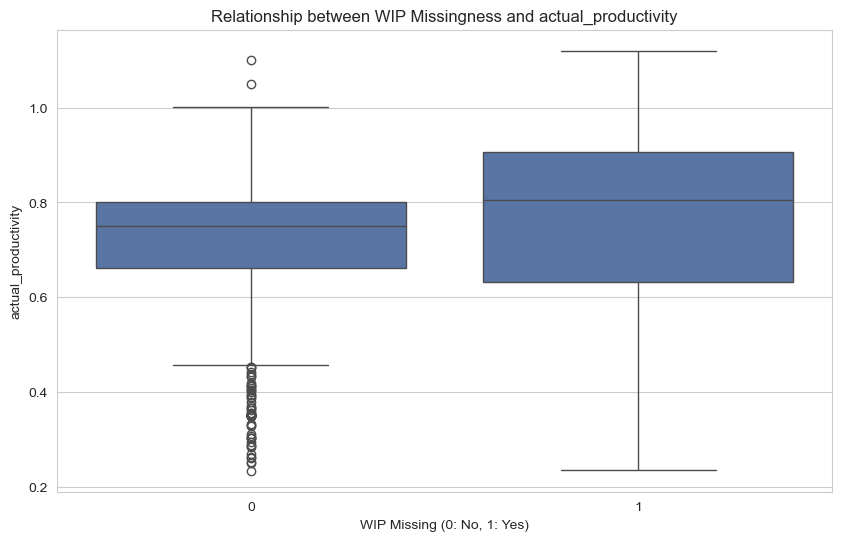

T-test results for actual_productivity:
t-statistic: 3.0408
p-value: 0.0024



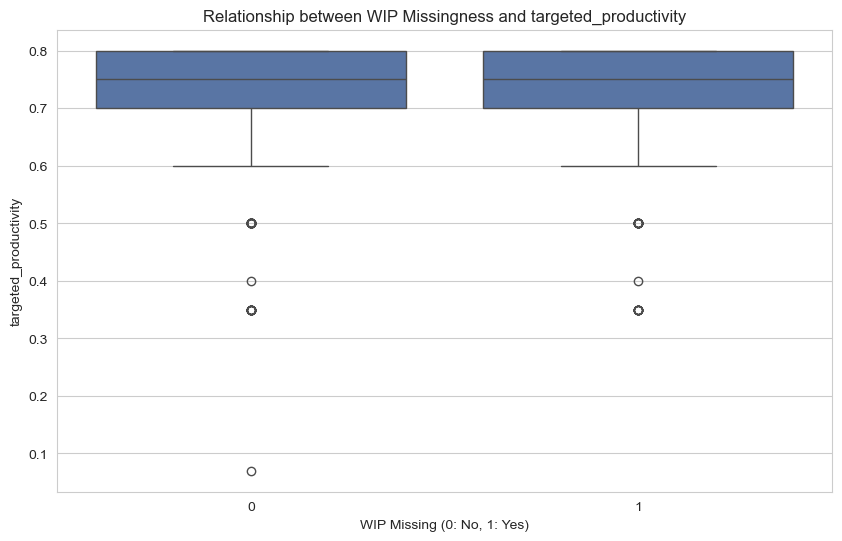

T-test results for targeted_productivity:
t-statistic: 2.3390
p-value: 0.0195



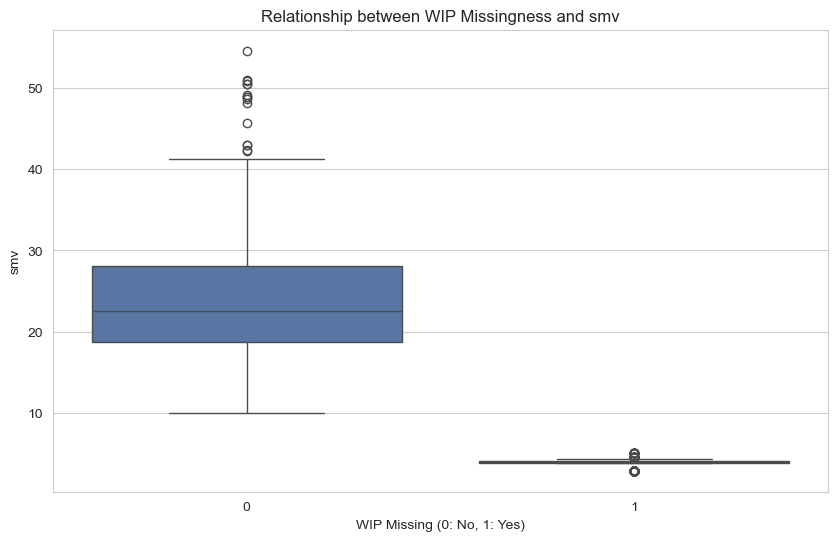

T-test results for smv:
t-statistic: -62.2456
p-value: 0.0000



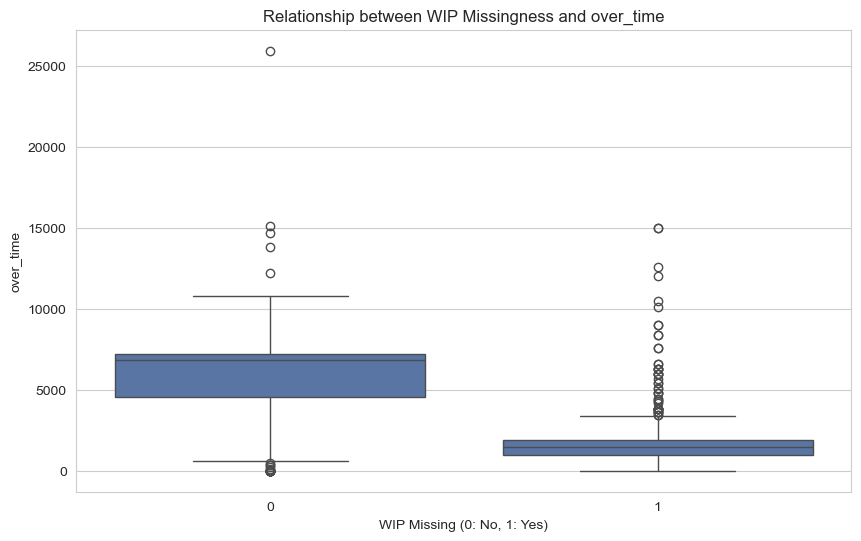

T-test results for over_time:
t-statistic: -31.8434
p-value: 0.0000



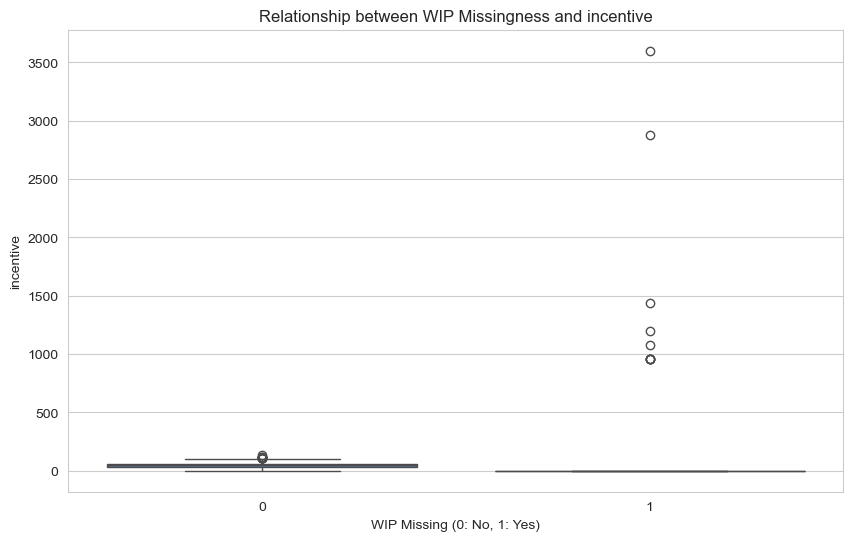

T-test results for incentive:
t-statistic: -1.5843
p-value: 0.1134



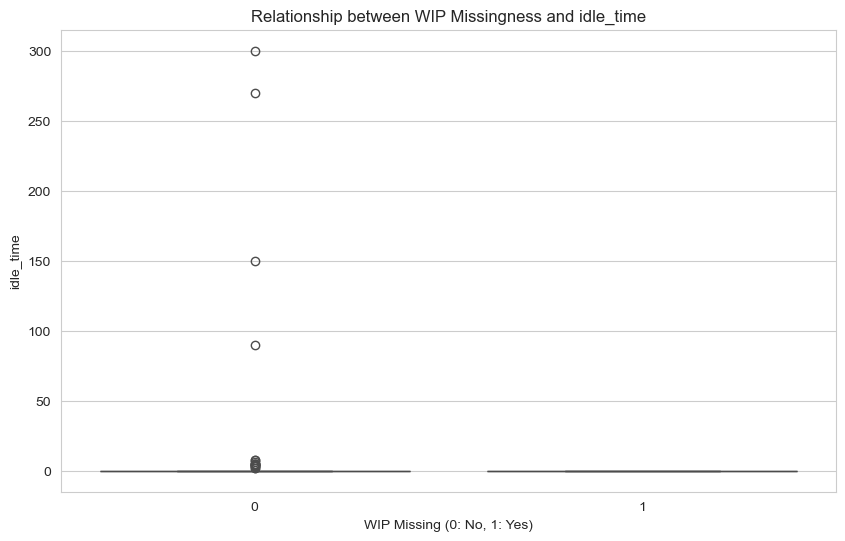

T-test results for idle_time:
t-statistic: -1.7022
p-value: 0.0890



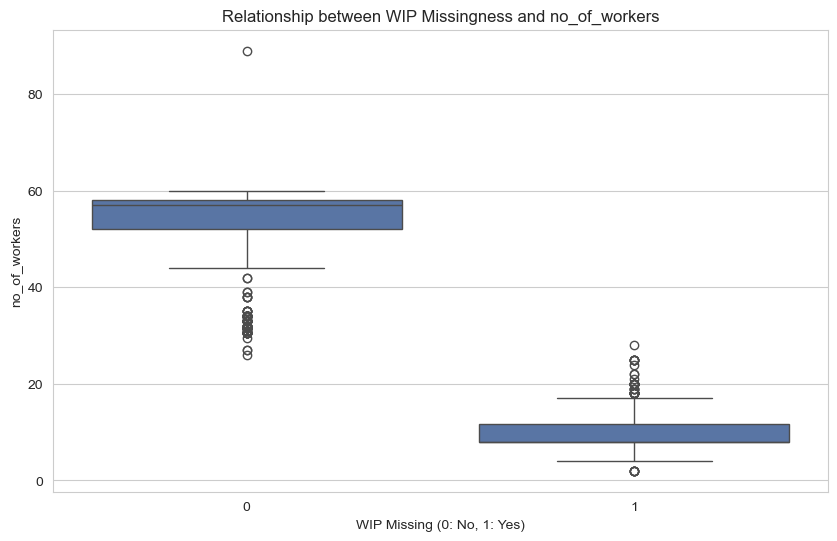

T-test results for no_of_workers:
t-statistic: -94.6904
p-value: 0.0000

Chi-square test results for quarter:
chi-square statistic: 2.0835
p-value: 0.5553

Chi-square test results for department:
chi-square statistic: 1192.9056
p-value: 0.0000

Chi-square test results for day:
chi-square statistic: 0.6987
p-value: 0.9830

Chi-square test results for team:
chi-square statistic: 9.7466
p-value: 0.5533

Overall summary of WIP missingness:
wip_missing
0    0.577277
1    0.422723
Name: proportion, dtype: float64


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming productivity_df is your original DataFrame
# Create a binary indicator for WIP missingness
productivity_df['wip_missing'] = productivity_df['wip'].isna().astype(int)

# Function to plot relationship between WIP missingness and a numeric variable
def plot_missingness_relationship(df, var_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='wip_missing', y=var_name, data=df)
    plt.title(f'Relationship between WIP Missingness and {var_name}')
    plt.xlabel('WIP Missing (0: No, 1: Yes)')
    plt.ylabel(var_name)
    plt.show()
    
    # Perform t-test
    missing = df[df['wip_missing'] == 1][var_name]
    not_missing = df[df['wip_missing'] == 0][var_name]
    t_stat, p_value = stats.ttest_ind(missing, not_missing)
    print(f"T-test results for {var_name}:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}\n")

# List of numeric variables to investigate
numeric_vars = ['actual_productivity', 'targeted_productivity', 'smv', 'over_time', 'incentive', 'idle_time', 'no_of_workers']

# Plot and test for each numeric variable
for var in numeric_vars:
    plot_missingness_relationship(productivity_df, var)

# For categorical variables, we can use a chi-square test
def chi_square_test(df, cat_var):
    contingency_table = pd.crosstab(df['wip_missing'], df[cat_var])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-square test results for {cat_var}:")
    print(f"chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}\n")

# List of categorical variables
cat_vars = ['quarter', 'department', 'day', 'team']

# Perform chi-square test for each categorical variable
for var in cat_vars:
    chi_square_test(productivity_df, var)

# Overall summary of missingness
print("Overall summary of WIP missingness:")
print(productivity_df['wip_missing'].value_counts(normalize=True))

Let's analyze them in detail to understand the patterns of missingness in the 'wip' variable:

1. Number of Workers (no_of_workers):
- T-statistic: -94.6904
- P-value: 0.0000 (extremely small)
- There is a highly significant difference in the number of workers between cases where 'wip' is missing and where it's not. The negative t-statistic suggests that 'wip' is more likely to be missing when there are fewer workers. This could indicate that 'wip' data is harder to collect or less likely to be recorded for smaller teams or operations.
2. Quarter:
- Chi-square statistic: 2.0835
- P-value: 0.5553
- There is no significant association between the quarter and 'wip' missingness. This suggests that the time of year does not affect whether 'wip' data is recorded or not.
3. Department:
- Chi-square statistic: 1192.9056
- P-value: 0.0000 (extremely small)
- There is a very strong association between the department and 'wip' missingness. This indicates that some departments are much more likely to have missing 'wip' data than others. This could be due to differences in data collection practices, the nature of work in different departments, or varying levels of adherence to data recording protocols.
4. Day:
- Chi-square statistic: 0.6987
- P-value: 0.9830
- There is no significant association between the day of the week and 'wip' missingness. The day of the week does not appear to influence whether 'wip' data is recorded or not.
5. Team:
- Chi-square statistic: 9.7466
- P-value: 0.5533
- There is no significant association between the team and 'wip' missingness. This suggests that the specific team doesn't influence whether 'wip' data is recorded or not.


In [1]:
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1' 

# import rpy2's package module
from rpy2.robjects.packages import importr
from functools import partial
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

%load_ext rpy2.ipython

c:\Users\ASUS TUF\anaconda3\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x00000150C9367810> [0]

In [2]:
from rpy2 import robjects
import rpy2.robjects.packages as rpackages

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages("DirichletReg")
DirichletReg = rpackages.importr("DirichletReg")

R[write to console]: Warning in (function (pkgs, lib, repos = getOption("repos"), contriburl = contrib.url(repos,  :
R[write to console]: 
 
R[write to console]:  'lib = "C:/Program Files/R/R-4.4.1/library"' is not writable

R[write to console]: Error in (function (pkgs, lib, repos = getOption("repos"), contriburl = contrib.url(repos,  : 
  unable to install packages



RRuntimeError: Error in (function (pkgs, lib, repos = getOption("repos"), contriburl = contrib.url(repos,  : 
  unable to install packages


In [3]:
from rpy2.robjects.vectors import StrVector

package_names = ('ggplot2')
utils.install_packages(StrVector(package_names))

R[write to console]: Warning in (function (pkgs, lib, repos = getOption("repos"), contriburl = contrib.url(repos,  :
R[write to console]: 
 
R[write to console]:  'lib = "C:/Program Files/R/R-4.4.1/library"' is not writable



# Data Splitting

In [5]:
X = productivity_prediction_of_garment_employees.data.features 
y = productivity_prediction_of_garment_employees.data.targets 
  
# metadata 
print(productivity_prediction_of_garment_employees.metadata) 
  
# variable information 
print(productivity_prediction_of_garment_employees.variables) 


{'uci_id': 597, 'name': 'Productivity Prediction of Garment Employees', 'repository_url': 'https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees', 'data_url': 'https://archive.ics.uci.edu/static/public/597/data.csv', 'abstract': 'This dataset includes important attributes of the garment manufacturing process and the productivity of the employees which had been collected manually and also been validated by the industry experts.', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 1197, 'num_features': 14, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['actual_productivity'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C51S6D', 'creators': [], 'intro_paper': {'title': 'Mining the productivity data of the garment industry', '